In [12]:
import pandas as pd
import re
import numpy as np
from nltk.corpus import stopwords
import nltk
stop_words_es = nltk.corpus.stopwords.words('spanish')
stop_words_pt = nltk.corpus.stopwords.words('portuguese')
from nltk.stem.snowball import SnowballStemmer
stem_es = SnowballStemmer('spanish')
stem_pt = SnowballStemmer('portuguese')
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm

In [3]:
### data source: https://chequeado.com/latamcoronavirusportugues/
import csv
df = pd.read_csv("./raw-data/Basededatos-Latamcoronavirus.csv",
                 warn_bad_lines=False,
           encoding = 'utf-8',error_bad_lines=False, sep=',',quoting=csv.QUOTE_MINIMAL)

In [4]:
import unicodedata
def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")

    return str(text)

In [5]:
import stanza
# stanza.download('es') 
# stanza.download('pt') 

nlp_es = stanza.Pipeline(lang='es')
nlp_pt = stanza.Pipeline(lang='pt')

2021-04-12 21:34:29 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2021-04-12 21:34:29 INFO: Use device: cpu
2021-04-12 21:34:29 INFO: Loading: tokenize
2021-04-12 21:34:29 INFO: Loading: mwt
2021-04-12 21:34:29 INFO: Loading: pos
2021-04-12 21:34:30 INFO: Loading: lemma
2021-04-12 21:34:30 INFO: Loading: depparse
2021-04-12 21:34:30 INFO: Loading: ner
2021-04-12 21:34:31 INFO: Done loading processors!
2021-04-12 21:34:31 INFO: Loading these models for language: pt (Portuguese):
| Processor | Package |
-----------------------
| tokenize  | bosque  |
| mwt       | bosque  |
| pos       | bosque  |
| lemma     | bosque  |
| depparse  | bosque  |

2021-04-12 21:34:31 INFO: Use device: cpu
2021-04-12 21:34:31 INFO: Loading: tokenize
2021-04-12 21:34:31 INFO: Loading: mwt
2021-04-12 21:34:31 I

In [6]:
df.Idioma.unique()

array(['Espanhol', 'Português'], dtype=object)

In [7]:
df.head()

,País,Idioma,Afirmação checada,Classificação,Descrição,Data de publicação,Organização,Link para a checagem,Tipo de informação,Formato,Tipo de checagem,Publicação checada,Data em que a desinformação foi detectada,Origem,Fonte,Foi atualizado ou corrigido?,Outros países onde circulou
0,Argentina,Espanhol,Confirmado um caso de Coronavírus em Santiago ...,Falso,O Ministério da Saúde da província afirmou que...,27/02/2020,Chequeado,https://chequeado.com/verificacionfb/no-no-se-...,Situação de um país,Imagem,Notícia falsa viralizada,https://drive.google.com/file/d/18MViCcWRoVVVg...,26/02/2020,Facebook,Desconhecido,NaN,NaN
1,Argentina,Espanhol,Confirmado um caso de Coronavírus em Chaco.,Falso,O Ministério da Saúde da província afirmou que...,27/02/2020,Chequeado,https://chequeado.com/verificacionfb/es-falso-...,Situação de um país,Imagem,Notícia falsa viralizada,https://drive.google.com/file/d/1SJ2-A3WCr-vod...,NaN,Facebook,Desconhecido,NaN,NaN
2,Argentina,Espanhol,Um médico argentino descobriu e está aplicando...,Falso,A OMS informa que até o momento não existe uma...,27/02/2020,Chequeado,https://chequeado.com/verificacionfb/es-falso-...,Curas,"Imagem, Texto",Notícia falsa viralizada,https://drive.google.com/file/d/1FYpMz5CN3ZyyS...,NaN,"Redes sociais, Whatsapp",Desconhecido,NaN,Espanha
3,Argentina,Espanhol,"Presidente da Argentina, Alberto Fernández: “A...",Falso,A OMS não emitiu nenhuma recomendação sobre o ...,12/03/2020,Chequeado,https://chequeado.com/ultimas-noticias/alberto...,Curas,Áudio,Checagem de figuras públicas,NaN,03/12/2020,Outros,"O presidente de Argentina, Alberto Fernández",NaN,"Espanha, Hong Kong, Colômbia"
4,Argentina,Espanhol,"O presidente de Argentina, Alberto Fernández, ...",Não se sustenta,Ainda não existe consenso científico sobre o i...,12/03/2020,Chequeado,https://chequeado.com/ultimas-noticias/alberto...,Características do vírus,Áudio,Checagem de figuras públicas,NaN,03/12/2020,Outros,"O presidente de Argentina, Alberto Fernández",NaN,México


In [10]:
df = df[df.País.isin(["Brasil", "Portugal"])]

In [13]:
the_df = pd.DataFrame()
## clean/prepare text
for text, desc, outcome, lang in tqdm(zip(df['Afirmação checada'].tolist(), df['Descrição'].tolist(), df['Classificação'].tolist(), df['Idioma'].tolist()), total=len(df['Afirmação checada']), position=0, leave=True):
    
    # remove accents
    text = strip_accents(text)
    
    # only keep words (remove other characters)
    tmp_read = re.sub('[^a-zA-Z]+', ' ', text).lower()
    tmp_read_dsc = re.sub('[^a-zA-Z]+', ' ', desc).lower()
    
    if lang=='Espanhol':
        #Tokenization and remove stop words
        tmp_read = [word for word in tmp_read.split() if word not in stop_words_es]
        tmp_read_dsc = [word for word in tmp_read_dsc.split() if word not in stop_words_es]
        # stemming
        tmp_read_stm = [stem_es.stem(word) for word in tmp_read]
        tmp_read_dsc_stm = [stem_es.stem(word) for word in tmp_read_dsc]
        # lemminization
        doc = nlp_es(" ".join(tmp_read))
        tmp_read_lem = [word.lemma for sent in doc.sentences for word in sent.words]
        doc_desc = nlp_es(" ".join(tmp_read))
        tmp_read_dsc_lem = [word.lemma for sent in doc_desc.sentences for word in sent.words]
    elif lang=='Português':
        #Tokenization and remove stop words
        tmp_read = [word for word in tmp_read.split() if word not in stop_words_pt]
        tmp_read_dsc = [word for word in tmp_read_dsc.split() if word not in stop_words_pt]
        # stemming
        tmp_read_stm = [stem_pt.stem(word) for word in tmp_read]
        tmp_read_dsc_stm = [stem_pt.stem(word) for word in tmp_read_dsc]
        # lemminization
        doc = nlp_pt(" ".join(tmp_read))
        tmp_read_lem = [word.lemma for sent in doc.sentences for word in sent.words]
        doc_desc = nlp_pt(" ".join(tmp_read))
        tmp_read_dsc_lem = [word.lemma for sent in doc_desc.sentences for word in sent.words]
    
    # rejoin textiews
    tmp_read = ' '.join(tmp_read)
    tmp_read_stm = ' '.join(tmp_read_stm)
    tmp_read_lem = ' '.join(tmp_read_lem)
    tmp_read_dsc = ' '.join(tmp_read_dsc)
    tmp_read_dsc_stm = ' '.join(tmp_read_dsc_stm)
    tmp_read_dsc_lem = ' '.join(tmp_read_dsc_lem)
    
    # add to new df
    tmp = pd.DataFrame([text], columns=['original title'])
    tmp['body_title'] = tmp_read
    tmp['body_stem_title'] = tmp_read_stm
    tmp['body_lem_title'] = tmp_read_lem
    
    tmp['body_desc'] = tmp_read_dsc
    tmp['body_stem_desc'] = tmp_read_dsc_stm
    tmp['body_lem_desc'] = tmp_read_dsc_lem
#     tmp['body_dict'] = dict_read
#     tmp['body_dict_stem'] = dict_read_stm
    tmp['classification'] = outcome

    the_df = the_df.append(tmp, ignore_index=True)

100%|██████████| 1120/1120 [03:49<00:00,  4.87it/s]


In [17]:
# the_df.to_csv("./output-data/portuguese_df.csv", index=False)

In [16]:
# readd country, language, and media
the_df = pd.concat([the_df, df[["País","Idioma","Origem",'Descrição','Data de publicação']]], axis=1)
the_df = the_df.rename({"Descrição": "original description"}, axis=1)

In [128]:
# the_df.to_csv("./output-data/processed_text.csv", index=False)

In [158]:
def article_length(the_df, colname):
    '''count number of words in each speech'''
    l = pd.Series.tolist(the_df[[colname]])
    ct = 0
    count_per_speech = []
    for line in l:
        for i in line:
            i = i.split()
            ct += 1
            count_per_speech.append(len(i))
    the_df['total_'+colname] = count_per_speech
    return(the_df)

In [171]:
the_df = article_length(the_df, 'original title')
the_df = article_length(the_df, 'original description')

In [173]:
def summary_stats(the_df, colname):
    '''sent_length = num of sentences in speech
       num_word_unique = num of unique words in speech'''
    from nltk.tokenize import sent_tokenize, word_tokenize
    
    sent_len = []
    unique_len = []
    punctuations = '''!()-[]{}';:'"\,<>./?@#$%^&*_~``'''
    ct = 0
    for i in the_df[colname]:
        sents = sent_tokenize(i)
        tmp = word_tokenize(i)
        tmp_words = [i.lower() for i in tmp if i not in punctuations]
        
        tmp_unique = len(set(tmp))
        tmp_words = ' '.join(tmp_words)
        sent_len.append(len(sents))
        unique_len.append(tmp_unique)

    the_df['sent_length_'+colname] = sent_len
    the_df['num_word_unique_'+colname] = unique_len
    return(the_df)

In [174]:
the_df = summary_stats(the_df, 'original title')
the_df = summary_stats(the_df, 'original description')

### Sentiment Analysis

In [133]:
# https://pypi.org/project/sentiment-analysis-spanish/
from sentiment_analysis_spanish import sentiment_analysis
sentiment = sentiment_analysis.SentimentAnalysisSpanish()

/Users/kristenakey/opt/anaconda3/envs/maps/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/kristenakey/opt/anaconda3/envs/maps/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [288]:
the_df['body_stem_title_sent'] = [sentiment.sentiment(i) if lang=="Espanhol" else "-" for i,lang in zip(the_df.body_stem_title, the_df.Idioma)]
the_df['body_stem_desc_sent'] = [sentiment.sentiment(i) if lang=="Espanhol" else "-" for i,lang in zip(the_df.body_stem_desc, the_df.Idioma)]

In [309]:
the_df['body_lem_title_sent'] = [sentiment.sentiment(i) if lang=="Espanhol" else "-" for i,lang in zip(the_df.body_lem_title, the_df.Idioma)]
the_df['body_lem_desc_sent'] = [sentiment.sentiment(i) if lang=="Espanhol" else "-" for i,lang in zip(the_df.body_lem_desc, the_df.Idioma)]

In [311]:
the_df['body_title_sent'] = [sentiment.sentiment(i) if lang=="Espanhol" else "-" for i,lang in zip(the_df.body_title, the_df.Idioma)]
the_df['body_desc_sent'] = [sentiment.sentiment(i) if lang=="Espanhol" else "-" for i,lang in zip(the_df.body_desc, the_df.Idioma)]

In [315]:
the_df

,original title,body_title,body_stem_title,body_lem_title,body_desc,body_stem_desc,body_lem_desc,classification,País,Idioma,...,num_word_unique_original title,sent_length_original description,num_word_unique_original description,body_stem_title_sent,body_stem_desc_sent,Data de publicação,body_lem_title_sent,body_lem_desc_sent,body_title_sent,body_desc_sent
0,Confirmado um caso de Coronavirus em Santiago ...,confirmado um caso coronavirus em santiago estero,confirm um cas coronavirus em santiag ester,confirmado um caso coronavirus em santiago estero,minist rio da sa da prov ncia afirmou tratava ...,minist rio da sa da prov nci afirmou tratav um...,confirmado um caso coronavirus em santiago estero,Falso,Argentina,Espanhol,...,9,1,14,0.497892,0.219122,27/02/2020,0.253474,0.253474,0.253474,0.219122
1,Confirmado um caso de Coronavirus em Chaco.,confirmado um caso coronavirus em chaco,confirm um cas coronavirus em chac,confirmado um caso coronavirus em chaco,minist rio da sa da prov ncia afirmou tratava ...,minist rio da sa da prov nci afirmou tratav um...,confirmado um caso coronavirus em chaco,Falso,Argentina,Espanhol,...,8,1,14,0.497892,0.219122,27/02/2020,0.253474,0.253474,0.253474,0.219122
2,Um medico argentino descobriu e esta aplicando...,um medico argentino descobriu aplicando uma va...,um medic argentin descobriu aplic uma vacin co...,umo medico argentino descobriar aplicar uma va...,oms informa at momento n existe uma vacina ou ...,oms inform at moment n exist uma vacin ou medi...,umo medico argentino descobriar aplicar uma va...,Falso,Argentina,Espanhol,...,15,1,19,0.497892,0.497892,27/02/2020,0.497892,0.497892,0.497892,0.162545
3,"Presidente da Argentina, Alberto Fernandez: A ...",presidente da argentina alberto fernandez oms ...,president da argentin albert fernandez oms rec...,presidente dar argentino alberto fernandez oms...,oms n emitiu nenhuma recomenda consumo bebidas...,oms n emitiu nenhum recomend consum beb prev a...,presidente dar argentino alberto fernandez oms...,Falso,Argentina,Espanhol,...,20,1,25,0.345334,0.492445,12/03/2020,0.180586,0.180586,0.161323,0.214928
4,"O presidente de Argentina, Alberto Fernandez, ...",presidente argentina alberto fernandez disse c...,president argentin albert fernandez diss coron...,presidente argentino alberto fernandez disse c...,ainda n existe consenso cient fico impacto da ...,aind n exist consens cient fic impact da tempe...,presidente argentino alberto fernandez disse c...,Não se sustenta,Argentina,Espanhol,...,17,1,17,0.497892,0.345334,12/03/2020,0.666237,0.666237,0.666237,0.48678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3740,Hidroxicloroquin@ sendo aspirada na nebulizaca...,hidroxicloroquin sendo aspirada nebulizacao me...,hidroxicloroquin send aspir nebulizaca melhor ...,hidroxicloroquin ser aspirar nebulizacao melho...,n h estudos publicados revistas cient ficas pr...,n h estud public revist cient fic prov nebuliz...,hidroxicloroquin ser aspirar nebulizacao melho...,Falso,Brasil,Português,...,30,1,20,-,-,26/03/2021,-,-,-,-
3741,CPF CURA COVID EM SAO PAULO\nTerca-feira: reco...,cpf cura covid sao paulo terca feira recorde m...,cpf cur covid sao paul terc feir record mort q...,cpf cura covid ser paulo terco feira recordar ...,redu n mero bitos registrados ocorreu porque m...,redu n mer bit registr ocorr porqu minist rio ...,cpf cura covid ser paulo terco feira recordar ...,Exagerado,Brasil,Português,...,14,1,39,-,-,29/03/2021,-,-,-,-
3742,Preparando a cena terrivel de mortos para grav...,preparando cena terrivel mortos gravar so nao ...,prepar cen terrivel mort grav so nao esper mor...,preparar cena terrivel matar gravar so nao esp...,v deo circula redes sociais registro cenas vid...,v deo circul red soc registr cen videoclip eve...,preparar cena terrivel matar gravar so nao esp...,Falso,Brasil,Português,...,23,1,25,-,-,30/03/2021,-,-,-,-
3743,Olha a midia ai que mostra o que interessa do ...,olha midia ai mostra interessa 

In [306]:
the_df.body_stem_title

0             confirm um cas coronavirus em santiag ester
1                      confirm um cas coronavirus em chac
2       um medic argentin descobriu aplic uma vacin co...
3       president da argentin albert fernandez oms rec...
4       president argentin albert fernandez diss coron...
                              ...                        
3740    hidroxicloroquin send aspir nebulizaca melhor ...
3741    cpf cur covid sao paul terc feir record mort q...
3742    prepar cen terrivel mort grav so nao esper mor...
3743    olha mid ai mostr interess jeitinh continu ven...
3744    drogara prez client enorm satisfaca anunc inic...
Name: body_stem_title, Length: 3745, dtype: object

In [308]:
sentiment.sentiment('confirm um cas coronavirus em santiag ester')

0.49789225920557484

In [307]:
sentiment.sentiment('confirm um cas coronavirus em chac')

0.49789225920557484

In [305]:
[sentiment.sentiment(i) if lang=="Espanhol" else "-" for i,lang in zip(the_df.body_stem_title, the_df.Idioma)]

[0.49789225920557484,
 0.49789225920557484,
 0.49789225920557484,
 0.34533447752142954,
 0.49789225920557484,
 0.49789225920557484,
 0.49789225920557484,
 0.49789225920557484,
 0.49789225920557484,
 0.49789225920557484,
 0.34533447752142954,
 0.49789225920557484,
 0.2537377695429705,
 0.49789225920557484,
 0.49789225920557484,
 0.49789225920557484,
 0.34533447752142954,
 0.49789225920557484,
 0.49789225920557484,
 0.34533447752142954,
 0.34533447752142954,
 0.3749596440199391,
 0.34533447752142954,
 0.31857999659820957,
 0.34533447752142954,
 0.34533447752142954,
 0.49789225920557484,
 0.49789225920557484,
 0.49789225920557484,
 0.49789225920557484,
 0.49789225920557484,
 0.49789225920557484,
 0.49789225920557484,
 0.49789225920557484,
 0.49789225920557484,
 0.49789225920557484,
 0.47673437950362624,
 0.34533447752142954,
 0.49789225920557484,
 0.49789225920557484,
 0.49789225920557484,
 0.49789225920557484,
 0.35037246870997213,
 0.5017543432377519,
 0.8061061964474351,
 0.49789225920

In [298]:
# the_df.to_csv("./output-data/processed_text2.csv", index=False)

<AxesSubplot:xlabel='body_stem_title_sent', ylabel='Count'>

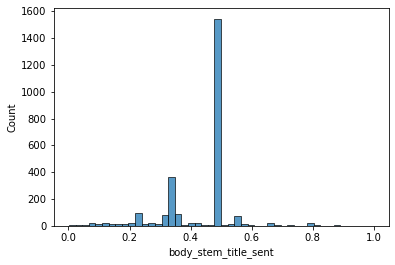

In [290]:
sub = the_df[the_df.body_stem_title_sent!="-"]
sns.histplot(sub, x="body_stem_title_sent",stat="count")

<AxesSubplot:xlabel='body_stem_desc_sent', ylabel='Count'>

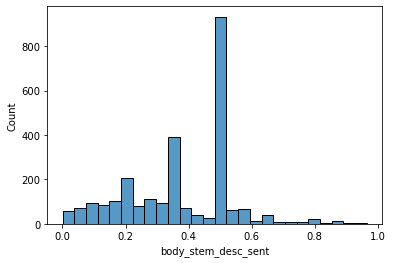

In [291]:
sub = the_df[the_df.body_stem_desc_sent!="-"]
sns.histplot(sub, x="body_stem_desc_sent",stat="count")

In [ ]:
### having trouble downloading pyplot to get Portugeuse sentiment analysis
## https://polyglot.readthedocs.io/en/latest/Sentiment.html

### Article source count

In [449]:
source_per_article = []
for i, ind in zip(the_df.Origem, the_df.index):
    source_per_article.append(len(str(i).split(", ")))

In [450]:
the_df['count_ind'] = source_per_article

In [451]:
source_unique = []
for source,i in zip(the_df['count_ind'], the_df['Origem']):
    if int(source)>1:
        source_unique.append(i.split(", "))
    else:
        source_unique.append([str(i)])
        
len(source_unique)

3745

In [452]:
flat_list = [item for sublist in source_unique for item in sublist]

In [453]:
len(flat_list)

4245

In [454]:
new_the_df = pd.DataFrame({col: np.repeat(the_df[col], the_df.count_ind) for col in the_df.columns})

In [455]:
new_the_df.shape

(4245, 27)

In [456]:
new_the_df['source'] = flat_list

In [457]:
new_the_df.source = [i.rstrip() for i in new_the_df.source]

In [459]:
new_the_df.source.unique()

array(['Facebook', 'Redes sociais', 'Whatsapp', 'Outros', 'Twitter',
       'Mídias', 'nan', 'Youtube', 'Veículo de comunicação', 'WhatsApp',
       'Veículos de comunicação', 'Email', 'Meios de comunicação',
       'Redes sociais e Vweículos de comunicação', 'Instagram', 'E-mail',
       'Portal oficial do Governo', 'Defensor do Povo do Peru',
       'Walter Gutiérrez', 'Portal Oficial do Governo', 'SMS',
       'Redes Sociais', 'Meio de comunicação', 'YouTube', 'sites',
       'Perfil do Presidente Jair Bolsonaro', 'veículo de comunicação',
       'Telegram', 'Blog', 'Website', 'Veículos de comunicação.',
       'Sites da internet', 'WhasApp', 'RedesSociais',
       'Meio de Comunicação', 'Twittter',
       'Ismael Reyes (candidato à presidência pelo Partido Democrata Institucional na República Dominicana)',
       'Leonel Fernández (candidato presidencial da Força do Povo (FP) na República Dominicana)',
       'Redes sociais Veículos de comunicação', 'meio de comunicação',
       'R

**Clean source names**

In [ ]:
new_the_df.loc[new_the_df.source.isin(['SMS','Telegram','Zoom',
                                       'Pânico na TV','radio show' ]), 
               "source"] = "Other (TV, Zoom, SMS, Radio, etc.)"

new_the_df.loc[new_the_df.source.isin(['Defensor do Povo do Peru', 'Ivan Arias (Ministro de Obras Públicas da Bolívia)',
                                       'Ismael Reyes (candidato à presidência pelo Partido Democrata Institucional na República Dominicana)', 
                                       'Jerônimo do Sertão (activist)', 'Leonel Fernández (candidato presidencial da Força do Povo (FP) na República Dominicana)', 
                                       'Cacau Menezes (journalist)', 'Perfil do Presidente Jair Bolsonaro', 'Cacau Menezes (jornalista)', 
                                       'Walter Gutiérrez', ]), "source"] = "Person"

new_the_df.loc[new_the_df.source.isin(['Veículos de comunicação.', 'Veículos de comunicaçãos', 
                                       'veículo de comunicação', "Veículo de comunicação",
                                       'Redes sociais Veículos de comunicação', 
                                       'Redes sociais e Vweículos de comunicação']), 
               "source"] = "Veículos de comunicação"

new_the_df.loc[new_the_df.source.isin(["meio de comunicação", "Meios de comunicação","Meio de Comunicação",
                                      "Meios de Comunicação"]), "source"] = "Meio de comunicação"

new_the_df.loc[new_the_df.source=="Facebok", "source"] = "Facebook"
new_the_df.loc[new_the_df.source=="Email", "source"] = "E-mail"
new_the_df.loc[new_the_df.source=="Twittter", "source"] = "Twitter"
new_the_df.loc[new_the_df.source=="YouTube", "source"] = "Youtube"
new_the_df.loc[new_the_df.source=="Desconhecido", "source"] = "nan"

new_the_df.loc[new_the_df.source.isin(['Annonymous Incision (website)', 'Stylo Urbano (website)', 
                                       'WhatsApp e Redes Sociais', 'Blog', 'Terça Livre (website)', 
                                       'Terra Brasil Online (website)', 'Terra Brasil Notícias (site)', 
                                       'sites', 'Sociedade Política (website)', '76GoGoNews (website)', 
                                       'Brasil 61 (website)', 'Brasil Sem Medo (website)', 
                                       'Contrafatos (website)', 'Diário do Brasil (website)', 
                                       'Diário do Poder (website)', 'Imprensa Brasil (website)', 
                                       'Mídia sem Máscara (website)', 'Portal oficial do Governo', 
                                       'Portal Oficial do Governo','Sites da internet', 
                                       'Meio de Comunicação (site)']), "source"] = "Website"

new_the_df.loc[new_the_df.source.isin(["WhatsApp","WhasApp",'WhasApp', 'WhtatsApp', 
                                       'WhatsApp e Redes Sociais']), "source"] = "Whatsapp"

new_the_df.loc[new_the_df.source.isin(["Redes sociais e WhatsApp", "Redes Sociais sociales",
                                      "Redes Sociais", "RedesSociais", "Redes Socais"]), "source"] = "Redes sociais"

In [446]:
new_the_df.groupby("source").count().sort_values("index",ascending=False)['index']

source
Redes sociais                         1598
Whatsapp                               747
nan                                    583
Facebook                               569
Twitter                                207
Veículos de comunicação                145
Youtube                                116
Outros                                  97
Meio de comunicação                     74
Mídias                                  39
Website                                 27
Instagram                               16
E-mail                                  11
Person                                   9
Other (TV, Zoom, SMS, Radio, etc.)       7
Name: index, dtype: int64

In [447]:
# new_the_df.to_csv("./output-data/source_count.csv", index=False)

### Topic Modeling 

In [470]:
# I added a bigram column to this dataframe earlier
bigram_lem = pd.read_csv("./output-data/df_bigrams_lem.csv")

In [516]:
# wordlist = [i.split() for i in the_df.body_lem_title]

In [529]:
wordlist2 = [str(i).split() for i in bigram_lem.bigram]
wordlist2

/Users/kristenakey/opt/anaconda3/envs/maps/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['umo', 'comerciante'],
 ['comerciante', 'hueco'],
 ['hueco', 'internado'],
 ['internado', 'em'],
 ['em', 'hospital'],
 ['hospital', 'medellin'],
 ['medellin', 'com'],
 ['com', 'sintoma'],
 ['sintoma', 'do'],
 ['do', 'coronavirus'],
 ['houve', 'mortes'],
 ['mortes', 'coronavirus'],
 ['coronavirus', 'em'],
 ['em', 'wuhan'],
 ['umo', 'video'],
 ['video', 'mercado'],
 ['mercado', 'onde'],
 ['onde', 'comecou'],
 ['comecou', 'coronavirus'],
 ['coronavirus', 'em'],
 ['em', 'wuhan'],
 ['coronavirus', 'chegou'],
 ['chegou', 'em'],
 ['em', 'cucuta'],
 ['coronavirus', 'espalha'],
 ['espalha', 'nas'],
 ['nas', 'cidad'],
 ['cidad', 'do'],
 ['do', 'equador'],
 ['as', 'autoridad'],
 ['autoridad', 'saude'],
 ['saude', 'confirmar'],
 ['confirmar', 'tres'],
 ['tres', 'caso'],
 ['caso', 'equador'],
 ['primeiro', 'paciente'],
 ['paciente', 'diagnosticar'],
 ['diagnosticar', 'com'],
 ['com', 'coronavirus'],
 ['coronavirus', 'morreu'],
 ['ministerio', 'dar'],
 ['dar', 'saude'],
 ['saude', 'demitiu'],
 ['d

In [530]:
dictionary = corpora.Dictionary(wordlist2)
corpus = [dictionary.doc2bow(text) for text in wordlist2]

/Users/kristenakey/opt/anaconda3/envs/maps/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [538]:
NUM_TOPICS = 6
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, 
                                           id2word=dictionary, 
                                           passes=25,
                                          random_state=99)

/Users/kristenakey/opt/anaconda3/envs/maps/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [539]:
topics = ldamodel.print_topics(num_words=8)
for topic in topics:
    print(topic)

(0, '0.058*"vacina" + 0.040*"as" + 0.025*"contra" + 0.024*"medico" + 0.017*"mais" + 0.016*"pela" + 0.012*"dizer" + 0.010*"virus"')
(1, '0.151*"covid" + 0.081*"do" + 0.023*"teste" + 0.019*"morte" + 0.018*"governo" + 0.016*"paciente" + 0.016*"dos" + 0.013*"brasileiro"')
(2, '0.069*"uma" + 0.056*"nao" + 0.030*"pessoa" + 0.023*"presidente" + 0.021*"sao" + 0.019*"umo" + 0.017*"mostrar" + 0.013*"corrente"')
(3, '0.138*"dar" + 0.069*"coronavirus" + 0.034*"mascara" + 0.024*"afirmar" + 0.024*"saude" + 0.021*"argentino" + 0.020*"novo" + 0.017*"ao"')
(4, '0.059*"com" + 0.054*"ser" + 0.025*"poder" + 0.018*"usar" + 0.016*"brasil" + 0.016*"paulo" + 0.014*"pelo" + 0.013*"tem"')
(5, '0.102*"em" + 0.075*"um" + 0.052*"na" + 0.030*"video" + 0.025*"pandemia" + 0.018*"uso" + 0.017*"cura" + 0.016*"o"')


/Users/kristenakey/opt/anaconda3/envs/maps/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/kristenakey/opt/anaconda3/envs/maps/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


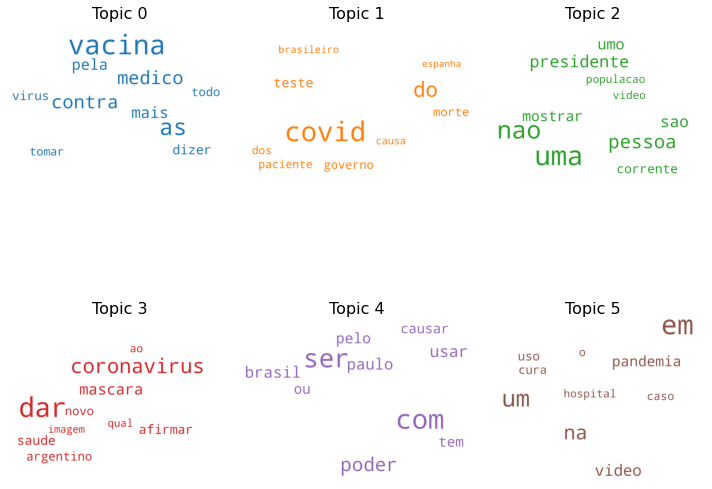

In [550]:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()